In [2]:
from random import sample
from als_model import ALSModel
from datasets import datasets
from multiprocessing import cpu_count
from collections import Counter
import matplotlib.pyplot as plt
from utils import get_empty_blob

In [3]:
test = ALSModel(
    dataset=datasets['10m'],
    biases_only=False,
    use_features=True,
    n_iter=10,
    dims=3,
    tau=.03,
    lambd=.02,
    gamma=.4,
    mu=.0,
    monitor=False,
    save_figures=True,
    save_history=True,
    n_jobs=cpu_count(),
)
test.load_parameters()

Loading data from dumps/10m/item_indexes.pkl
load took 3.44ms
Items : 10677
Loading data from dumps/10m/item_data_blob.pkl
load took 2.651sec
Loading data from dumps/10m/item_training.pkl
load took 1.720sec
Loading data from dumps/10m/item_testing.pkl
load took 382.32ms
Loading data from dumps/10m/user_indexes.pkl
load took 13.43ms
Users : 69878
Loading data from dumps/10m/user_data_blob.pkl
load took 5.360sec
Loading data from dumps/10m/user_training.pkl
load took 5.825sec
Loading data from dumps/10m/user_testing.pkl
load took 6.476sec
Loading data from dumps/10m/feature_indexes.pkl
load took 0.873ms
Loading data from dumps/10m/feature_name_indexes.pkl
load took 0.408ms
Loading data from dumps/10m/feature_index_names.pkl
load took 0.391ms
Features : 20
Loading data from dumps/10m/feature_items_data_blob.pkl
load took 1.14ms
Loading data from dumps/10m/item_features_data_blob.pkl
load took 3.69ms
__init__ took 22.474sec
biases_only=False
use_features=True
K = 3
Iteration = 10/10
Loss =

In [4]:
selected_movies_ids = [2, 1721, 318, 858, 58559, 2571, 2116, 39435, 6387, 6566, 6919, 7399, 26875, 45852, 48150,
                       4993, 5952, 7153, 588, 586, 589, 1240, 6537, 6401, 6691, 7392, 6379, 44761, 49571, 51666,
                       #2953, 1707, 7417, 3213, 33794, 940, 2006, 4896, 6518, 6785, 7885, 7936, 45730, 55232, 5219,
                       5816, 8368, 6125, 6123, 6160, 6257, 6273, 6323, 6366, 26049, 26124, 26110, 8861, 7153,
                       ]
#selected_movies_ids = [#586, 1707, 1717, 1721, 2116, 2571, 2953, 4993, 5952, 7153, 39435, 2006,
# 374, 255, 270, 147, 4396, 
#2297, 2989, 48877, 1441, 374, 43919, 2382, 4564, 255, 3169
#]

#drama = [48598, 49280, 49347, 49524, 49571, 50259]
#selected_movies_ids = drama

In [5]:
selected_movies_indexes = [test.item_indexes[str(i)] for i in selected_movies_ids]

In [6]:
n_ratings = [len(test.item_data_blob[i]) for i in selected_movies_indexes]
sum(n_ratings)

270329

In [188]:
features = []
for i in selected_movies_indexes:
    features.extend(test.item_features_data_blob[i])
counts = Counter([test.feature_index_name[index] for index in features])
counts

Counter({'Adventure': 13,
         'Children': 7,
         'Fantasy': 8,
         'Drama': 11,
         'Romance': 3,
         'Crime': 7,
         'Action': 14,
         'IMAX': 1,
         'Sci-Fi': 6,
         'Thriller': 8,
         'Animation': 2,
         'Western': 6,
         'Comedy': 4,
         'Film-Noir': 3,
         'Mystery': 5,
         'Horror': 8,
         'Musical': 3,
         'War': 3,
         'Documentary': 4})

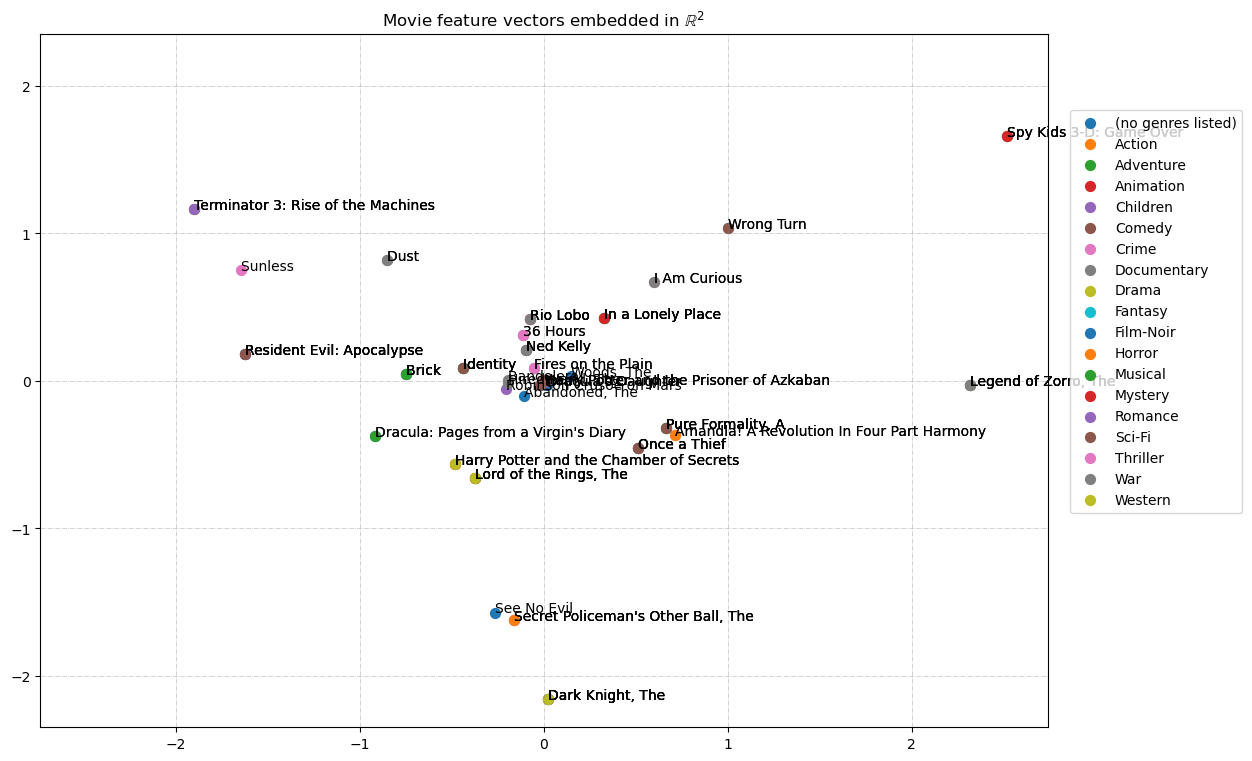

In [190]:
def plot_item_vectors_embedded(fi: int, model: str, save_figure: bool = True, threshold: int = 1000):
    features_items_vectors = get_empty_blob(len(test.feature_indexes))
    feature_vector = test.feature_vector[fi]
    labels = [key for key in test.feature_name_index]
    fig, ax = plt.subplots(figsize=(13, 9))
    scale = 1
    for item_index in selected_movies_indexes:
        item_vector = test.item_vector[item_index]
        for feature_index in test.item_features_data_blob[item_index]:
            features_items_vectors[feature_index].append((item_vector[0], item_vector[1], item_index))

    for feature_index, feature_items_vectors in enumerate(features_items_vectors):
        if feature_items_vectors:  #and feature_index == fi:
            random_text = [el for el in feature_items_vectors if len(test.item_data_blob[el[-1]]) <= threshold]
            xs = [feature_items_vector[0] for feature_items_vector in feature_items_vectors]
            ys = [feature_items_vector[1] for feature_items_vector in feature_items_vectors]
            ax.scatter(xs, ys, marker='o', s=50)
            for item_to_text in random_text:
                id_, name_ = test.get_items_from_file([item_to_text[2]])
                text = name_[0].split('(')[0]
                plt.annotate(text, (item_to_text[0], item_to_text[1]))

    # ax.scatter(feature_vector[0], feature_vector[1], marker='d', s=80)
    ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
    ax.set_title(r"Movie feature vectors embedded in $\mathbb{R}^2$")
    ax.legend(labels, bbox_to_anchor=(1.2, 0.6), loc='center right')
    # plt.tight_layout()
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    xabs_max = abs(max(ax.get_xlim(), key=abs))
    ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)

    if save_figure:
        plt.savefig(f'{test.fig_dir}{model}_{labels[fi]}_item_vectors_embedding.pdf')


plot_item_vectors_embedded(fi=8, model="B", save_figure=True, threshold=7000)

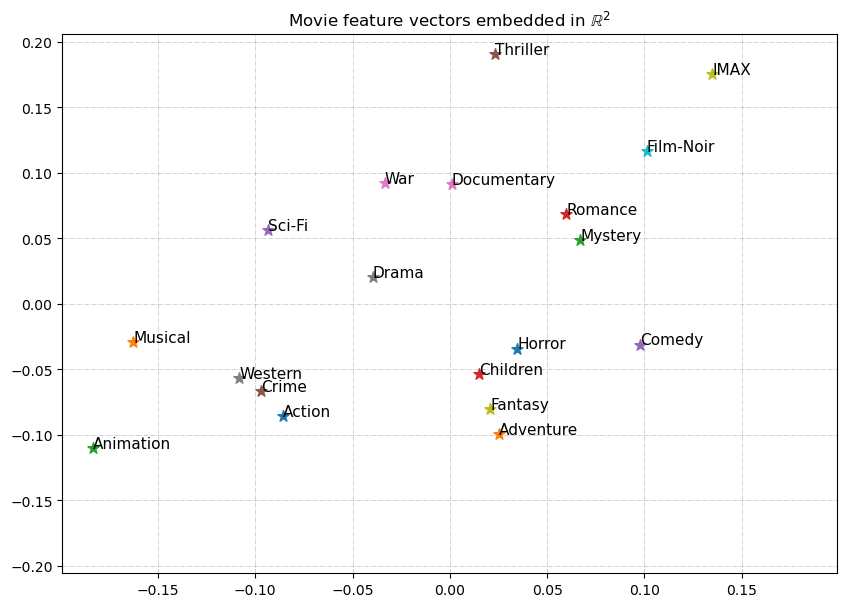

In [151]:
def plot_feature_vectors_embedded(save_figure: bool = True):
    fig, ax = plt.subplots(figsize=(10, 7))
    scale = 1
    for f_index, vector in enumerate(test.feature_vector):
        if f_index == 0:
            continue
        else:
            ax.scatter(scale * vector[0], scale * vector[1], marker='*', s=70)
            ax.annotate(test.feature_index_name[f_index], (scale * vector[0], scale * vector[1]), size=11)

    ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
    ax.set_title(r"Movie feature vectors embedded in $\mathbb{R}^2$")
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    xabs_max = abs(max(ax.get_xlim(), key=abs))
    ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)

    if save_figure:
        plt.savefig(f'{test.fig_dir}feature_vectors_embedding.pdf')


plot_feature_vectors_embedded(save_figure=True)

In [8]:
test.get_user_rated_one_item_recommendations(item_index=test.item_indexes['2116'])
Adventure|Animation|Children|Fantasy
Children|Comedy
Comedy
Drama|Romance
Drama
Action|Comedy

Recommendations for user that 5 star rated Lord of the Rings, The (1978)
+----+------+--------------------------------+--------------------+
| N  |  ID  |              Name              |       Rating       |
+----+------+--------------------------------+--------------------+
| 1  | 374  |       Richie Rich (1994)       |  25.9219400959324  |
| 2  | 255  |     Jerky Boys, The (1994)     | 24.426321822510626 |
| 3  | 270  |       Love Affair (1994)       | 21.808622508705206 |
| 4  | 147  | Basketball Diaries, The (1995) | 21.669186177791882 |
| 5  | 4396 |   Cannonball Run, The (1981)   | 19.521080324683776 |
| 6  | 2297 |  What Dreams May Come (1998)   | 18.423479959655584 |
| 7  | 2034 |     Black Hole, The (1979)     | 17.799254803333366 |
| 8  | 2025 |         Lolita (1997)          | 17.52442241638446  |
| 9  | 4006 | Transformers: The Movie (1986) | 17.35138116277892  |
| 10 | 1487 |         Selena (1997)          | 17.24008420796155  |
+----+------+------------------------------

(('374', 'Richie Rich (1994)', 25.9219400959324),
 ('255', 'Jerky Boys, The (1994)', 24.426321822510626),
 ('270', 'Love Affair (1994)', 21.808622508705206),
 ('147', 'Basketball Diaries, The (1995)', 21.669186177791882),
 ('4396', 'Cannonball Run, The (1981)', 19.521080324683776),
 ('2297', 'What Dreams May Come (1998)', 18.423479959655584),
 ('2034', 'Black Hole, The (1979)', 17.799254803333366),
 ('2025', 'Lolita (1997)', 17.52442241638446),
 ('4006', 'Transformers: The Movie (1986)', 17.35138116277892),
 ('1487', 'Selena (1997)', 17.24008420796155))